### Deep Q-network

Have a network estimating $Q_w(s, a)$. $\pi$ is eps-soft of $Q$
1. Sample action and perform it
2. Sample minibatch from experience replay
3. Perform Bellman update: $\sum\limits_{s, a, r, s'}\left(r+\max_{a'}Q_{w_0}(s', a')-Q_w(s, a)\right)^2$

Having collected experience D

In [353]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [354]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [414]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin',
 '/localhome/volodin/local/usr/bin',
 '/localhome/volodin/local/usr/bin']

In [415]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [416]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [417]:
env = gym.make('CartPole-v0')

In [461]:
# number of dimensions in state
S_DIM = 4

# number of available actions
ACTIONS = 2

# discount factor
gamma_discount = 0.9

# epsilon-greedy
eps = 0.1

# for softmax
temperature = 1

In [462]:
# states: double the length of actions: from-to-from-to...
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

# need next q-value (non-terminal state?)
need_next_q = tf.placeholder(tf.float64, shape = (None, ))

def fc_layer(x, n, activation = tf.nn.relu):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [463]:
class ExperienceReplay():
    def __init__(self, N = 1000):
        """ Create experience buffer with capacity N """
        self.N = N
        self.buf = []
    def store(self, exp):
        """ Store one experience """
        self.buf.append(exp)
        
        # removing extra elements
        extra = len(self.buf) - self.N
        if extra:
            self.buf = self.buf[extra:]
            
    def sample(self, how_many = 10):
        """ Sample a mini-batch from the buffer """
        assert len(self.buf) > 0, "Experience buffer is empty, cannot sample"
        indices = np.random.choice(len(self.buf), how_many)
        result = [self.buf[i] for i in indices]
        return result

In [464]:
# state is an input to the network
z = states

# some fully connected stuff
z = fc_layer(z, 10)

# some fully connected stuff
#z = fc_layer(z, 10)

# Q network head
with tf.name_scope('q_layers'):
    #z = fc_layer(z, 10)
    z_policy = fc_layer(z, 10)
    z_policy = fc_layer(z_policy, ACTIONS, activation = None)
    q_values = z_policy
    #logits_policy = tf.nn.softmax(z_policy)
    # predicted labels
    logits_policy = tf.nn.softmax(temperature * q_values)
    labels = tf.argmax(q_values, axis = 1)

In [465]:
# q-values from-to, equal length
q_values_from = q_values[0::2, :]
q_values_to = q_values[1::2, :]

In [466]:
params = tf.trainable_variables()

In [467]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken Q value (from)
q_taken = tf.boolean_mask(q_values_from, a_one_hot)

# maximal Q value
q_max   = tf.reduce_max(tf.stop_gradient(q_values_to), axis = 1)

In [468]:
def mse(x, y):
    return tf.reduce_mean(tf.square(x - y))

In [469]:
loss = mse(rewards + gamma_discount * tf.multiply(need_next_q, q_max), q_taken)

In [470]:
def replay_test():
    replay = ExperienceReplay()
    replay.store([1,2])
    replay.store([3,4])
    rs = replay.sample()
    assert [1,2] in rs or [3,4] in rs
replay_test()

In [471]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    if np.random.random() <= eps:
        return env.action_space.sample()
    
    p = sess.run(logits_policy, feed_dict = {states: [observation]})[0]
    return np.argmax(p)
    return np.random.choice(range(2), p = p)

In [472]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sars = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        curr = (observation, act, reward, observation_, True)
        sars.append(curr)
        replay.store(curr)
        
        if done:
            replay.store((observation_, sample_action(observation_), reward, observation_, False))
        
        observation = observation_
    env.close()
    #print(len(replay.buf), len(sars))
    return sars

In [473]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [474]:
# one learning iteration
step = opt

In [475]:
def interleave(A, B):
    """ Interleave two lists A, B: a1b1a2b2... """
    # https://stackoverflow.com/questions/7946798/interleave-multiple-lists-of-the-same-length-in-python
    assert len(A) == len(B), "Must have arrays of same length"
    return [val for tup in zip(A, B) for val in tup]
assert interleave([1,2,3],[4,5,6]) == [1, 4, 2, 5, 3, 6]

In [476]:
def train_step():
    # making one environment episode
    z = get_rollout()
    L = len(z)
    
    # sampling same size
    S0, A, R, S1, N = list(zip(*replay.sample(L)))
    
    sess.run(step, feed_dict = {states: interleave(S0, S1), actions: A, rewards: R, need_next_q: N})
    return np.sum(R)

In [477]:
init = tf.global_variables_initializer()
sess.run(init)
replay = ExperienceReplay()
r = []

In [486]:
get_rollout()
L = 10

# sampling same size
S0, A, R, S1, N = list(zip(*replay.sample(L)))
    
sess.run([need_next_q, rewards + gamma_discount * q_max, q_taken, loss], feed_dict = {states: interleave(S0, S1), actions: A, rewards: R, need_next_q: N})

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([4.61409696, 4.17879046, 4.86230043, 3.45534289, 6.52190306,
        2.70621133, 4.76249257, 2.62864375, 4.6272501 , 5.34331874]),
 array([3.55585797, 3.05349633, 3.79265232, 2.26417786, 5.58634041,
        1.71407335, 3.6921565 , 1.61201021, 3.5497818 , 4.31256946]),
 1.121133818805766]

In [482]:
eps = 0.1

In [483]:
for i in tqdm(range(1000)):
    r += [train_step()]

100%|██████████| 1000/1000 [00:03<00:00, 278.73it/s]


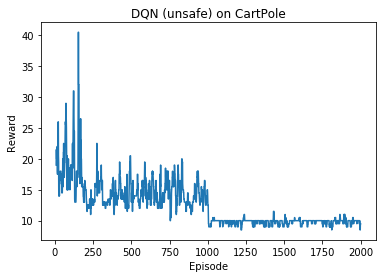

In [484]:
plt.figure()
plt.title('DQN (unsafe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(10).median())
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('dqn.eps', bbox_inches = 'tight')
plt.show()

In [89]:
len(get_rollout())

12

In [24]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [26]:
sess.run(params)

[array([[-0.18873484, -0.02347873, -0.09180877,  0.85437598,  0.73548765,
         -0.73257722, -0.62534989,  0.11622637,  0.20281138, -0.18195212],
        [ 0.59836861, -0.5312947 ,  0.40047014, -0.21417986, -0.07715603,
          0.31041685, -0.40055877, -0.73640866, -0.43643387,  0.42187376],
        [ 2.75277087, -2.28036003,  2.64911943, -2.98041001,  1.98106239,
          1.78692565, -2.19191594, -2.3974329 , -2.14004163,  2.22988617],
        [ 1.74699108, -1.05876661,  1.6915184 , -1.71513391,  2.09871922,
          2.09407334, -1.69480904, -1.17094075, -2.48597429,  2.29102605]]),
 array([-0.07335326, -0.08722787, -0.07997816, -0.15610739, -0.15218183,
        -0.01671254, -0.06472923, -0.10231432, -0.01664884, -0.13685326]),
 array([[-0.57068403,  0.57549599],
        [ 0.33537788, -0.67760173],
        [-0.45219608,  0.58277224],
        [ 0.27618997, -0.47491201],
        [-0.51973262,  0.21592388],
        [-1.157384  ,  0.60184666],
        [ 0.86199904, -0.71488893],
  

In [27]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [28]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
